# Temporal-Difference Methods  
---

Implementations of many Temporal-Difference (TD) methods.

### Cliff Walking Environment

In [11]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
from plot_utils import plot_values

import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [13]:
print('Action space: ', env.action_space.n)
print('States space: ', env.observation_space.n)

Action space:  4
States space:  48


#### Optimal state-value function

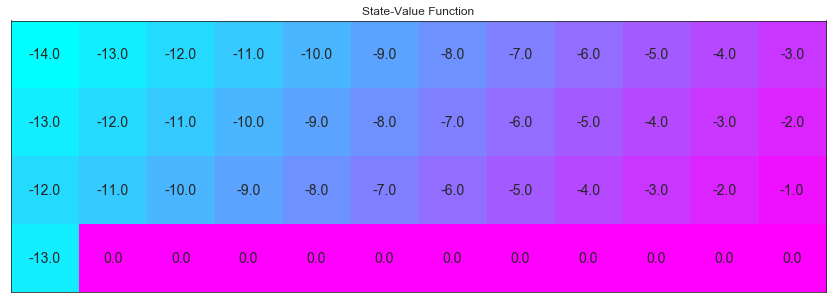

In [15]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', 'DeprecationWarning')

V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### 1 - SARSA 

SARSA has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [16]:
def update_Q(Qsa, Qsa_next, reward, alpha, gamma):
    '''
    Update Q-Table with the most recent estimate
    Each method will provide a different Qsa_next
    '''
    # Qt <- Qt + alpha(R + gamme*Qt+1 - Qt)
    return Qsa + (alpha * (reward + (gamma * Qsa_next) - Qsa))

def epsilon_greedy_probs(env, Q_s, i_episode, eps=None):
    '''
    Construct the policy from the Q-Table
    Returns the action probabilities following e-greedy policy - GLIE
    '''
    epsilon = eps if eps is not None else 1 / i_episode # eps update every iteration
    policy_s = np.ones(env.nA) * epsilon / env.nA       # e / |A| for non argmax 
    policy_s[np.argmax(Q_s)] = 1 - epsilon + (epsilon / env.nA) # 1-e + (e/|A|) for argmax
    return policy_s

def monitor(i, n):
    # Helper function to display the current episode
    if i % 100 == 0:
        print("\rEpisode {}/{}".format(i, n), end="")
        sys.stdout.flush()   

In [17]:
def sarsa(env, num_episodes, alpha, gamma=1.0):
    
    # Initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    
    # Initialize performance monitor
    plot_every = 100
    tmp_scores = deque(maxlen=plot_every)
    scores = deque(maxlen=num_episodes)
    ''' Python <deque>: list-like container with fast appends and pops on either end '''
    
    # loop over episodes
    for i_episode in range(1, num_episodes):
        
        # Monitor progress
        monitor(i_episode+1, num_episodes)
        
        # Reset environment 
        score = 0
        state = env.reset()
        
        # Assign probabilites for the next actions based on current policy: e-greedy probs
        policy_s = epsilon_greedy_probs(env, Q[state], i_episode) 
        
        # Pick action A with some random of picking another one
        action = np.random.choice(np.arange(env.nA), p=policy_s)  
        
        # Since TD methods don't run entire episode we can truncate them to avoid running forever
        truncate = 300
        for t_step in np.arange(truncate):
            
            # Take action Ar, observe Rt+1 and arrive to St+1
            next_state, reward, done, info = env.step(action)
            
            # Add observed Rt to the Accumulated Reward
            score += reward
            if not done:
                
                # Assign probabilites for the next actions based on current policy: e-greedy probs
                policy_s = epsilon_greedy_probs(env, Q[next_state], i_episode)
                
                # Pick next action At+1
                next_action = np.random.choice(np.arange(env.nA), p=policy_s)
                
                # Update Q-Values with the new estimate
                Q[state][action] = update_Q(Q[state][action], Q[next_state][next_action], reward, alpha, gamma)
                
                # St <- St+1 ;  At <- At+1
                state,action = next_state, next_action

            if done:
                
                # Update Q-Values with the new and last estimate
                Q[state][action] = update_Q(Q[state][action], 0, reward, alpha, gamma)
                
                # Append score
                tmp_scores.append(score)
                break
                
        if (i_episode % plot_every == 0):
            scores.append(np.mean(tmp_scores))
    
    # Plot results
    plt.plot(np.linspace(0,num_episodes,len(scores),endpoint=False),np.asarray(scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    
    # Print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(scores))
    return Q

Visualize the **_estimated_** optimal policy and the corresponding state-value function.  

Episode 5000/5000

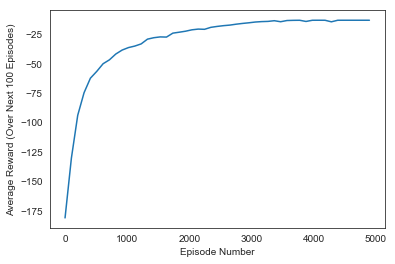

Best Average Reward over 100 Episodes:  -13.0

Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  1  1  1  1  2  2  2  1  1  2  2]
 [ 2  1  1  1  0  2  1  1  1  2  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


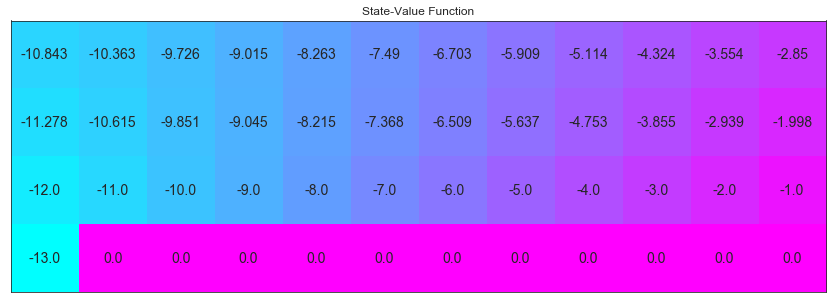

In [18]:
# Bbtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 5000, .01)

# Print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)

print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# Plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

### 2 - SARSAMAX: Q-learning

In [19]:
def q_learning(env, num_episodes, alpha, gamma=1.0):
    
    Q = defaultdict(lambda: np.zeros(env.nA))
    
    # Initialize performance monitor
    plot_every = 100
    tmp_scores = deque(maxlen=plot_every)
    scores = deque(maxlen=num_episodes)
    
    for i_episode in range(1, num_episodes+1):
       
        monitor(i_episode, num_episodes)
        
        # Reset environment 
        score = 0
        state = env.reset()
        while True:
            
            # Assign probabilites for the next actions based on current policy: e-greedy probs
            policy_s = epsilon_greedy_probs(env, Q[state], i_episode)
            
            # Pick action A with some random of picking another one
            action = np.random.choice(np.arange(env.nA), p=policy_s)  
            
            # Take action Ar, observe Rt+1 and arrive to St+1
            next_state, reward, done, info = env.step(action)
            
            # Add observed Rt to the Accumulated Reward
            score += reward
            
            # Update Q-Values pluging the Qmax before taking any other action
            Qt1 = np.max(Q[next_state])
            Q[state][action] = update_Q(Q[state][action], Qt1, reward, alpha, gamma)        
            
            # St <- St+1
            state = next_state

            # If episode ends
            if done:
                
                # Append score
                tmp_scores.append(score)
                break
        
        if (i_episode % plot_every == 0):
            scores.append(np.mean(tmp_scores))
    
    # Plot performance
    plt.plot(np.linspace(0,num_episodes,len(scores),endpoint=False),np.asarray(scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    
    # Print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(scores))
    return Q

Episode 5000/5000

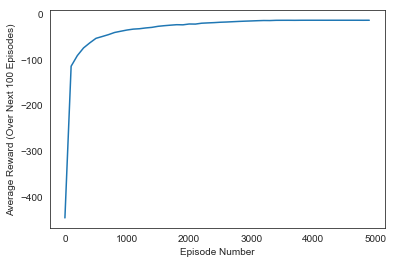

Best Average Reward over 100 Episodes:  -13.0

Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 2  3  1  2  1  1  3  0  3  1  1  2]
 [ 0  1  1  1  1  1  0  1  1  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


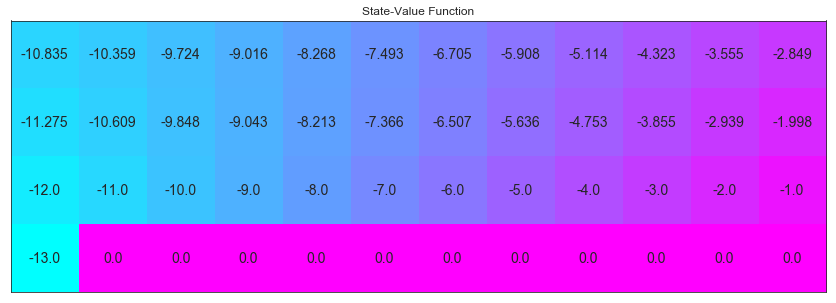

In [20]:
Q_sarsamax = q_learning(env, 5000, .01)

# Print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))

print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# Plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### 3 - Expected Sarsa

In [21]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0):
    
    Q = defaultdict(lambda: np.zeros(env.nA))
    
    # Initialize performance monitor
    plot_every = 100
    tmp_scores = deque(maxlen=plot_every)
    scores = deque(maxlen=num_episodes)
    
    for i_episode in range(1, num_episodes+1):
       
        monitor(i_episode, num_episodes)
        
        # Reset environment 
        score = 0
        state = env.reset()
        
        # Assign GLIE probabilities
        policy_s = epsilon_greedy_probs(env, Q[state], i_episode)
        
        while True:
            
            # Pick action A with some random of picking another one
            action = np.random.choice(np.arange(env.nA), p=policy_s)  
            
            # Take action Ar, observe Rt+1 and arrive to St+1
            next_state, reward, done, info = env.step(action)
            
            # Add observed Rt to the Accumulated Reward
            score += reward
            
            # Update Q-Values - weighted (according to the policy) sum of Q[St+1]]
            Qt1 = np.dot(Q[next_state], policy_s)
            Q[state][action] = update_Q(Q[state][action], Qt1, reward, alpha, gamma)        
            
            # St <- St+1
            state = next_state

            # If episode ends
            if done:

                # Append score
                tmp_scores.append(score)
                break
        
        if (i_episode % plot_every == 0):
            scores.append(np.mean(tmp_scores))
    
    # Plot performance
    plt.plot(np.linspace(0,num_episodes,len(scores),endpoint=False),np.asarray(scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    
    # Print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(scores))
    return Q

In [ ]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 10000, 1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)

print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])